# 逻辑回归-线性不可分

### 案例：设想你是工厂的生产主管，你要决定是否芯片要被接受或抛弃

### 数据集：ex2data2.txt,芯片在两次测试中的测试结果

In [1]:
import pandas as pd
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='dark', color_codes=False)  # 绘图风格设置
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
data=pd.read_csv('ex2data2.txt',engine='python',names=['Test 1','Test 2','Accepted'])#读取文件 
#相对路径必须要加.txt后缀，血泪教训#
data.head()# 读取前五行数据

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


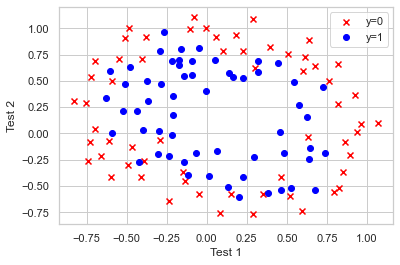

In [3]:
fig,ax = plt.subplots() #数据可视化
# c--散点颜色，marker--散点形状，label--散点标签
# data['Accepted']==0--判断接受值，['Test 1']--选择符合前面接收值的所有测试值
# data[data['Accepted']==0]['Test 1']表示在接受值为0时，所有exam1的符合值的横坐标
# data[data['Accepted']==0]['Test 1']表示在接受值为0时，所有exam2的符合值的纵坐标
ax.scatter(data[data['Accepted']==0]['Test 1'],data[data['Accepted']==0]['Test 2'],c='r',marker='x',label='y=0')
ax.scatter(data[data['Accepted']==1]['Test 1'],data[data['Accepted']==1]['Test 2'],c='b',marker='o',label='y=1')
ax.legend()#两个标签同时显示

ax.set(xlabel='Test 1',ylabel='Test 2')
plt.show()

### 特征映射 

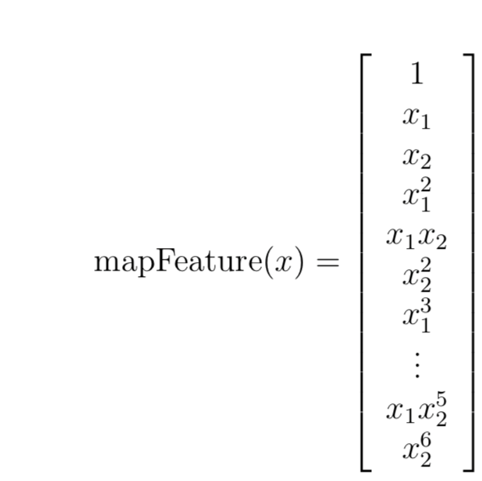

In [4]:
def feature_mapping(x1,x2,power):#构造特征映射函数，power表示映射阶次
    data = {} #设置一个空字典存储信息
    for i in np.arange(power+1):#外循环遍历0-power
        for j in np.arange(i+1):#内循环遍历0-i
            data['F{}{}'.format(i-j,j)] = np.power(x1,i-j) * np.power(x2,j)
            #data['F{}{}'.format(i-j,j)]等价于数组a[i-j][j]
            #np.power(a,b),a为底数，b为累乘阶次
    return pd.DataFrame(data)  #将data格式转换为DataFrame形式

In [5]:
x1=data['Test 1']
x2=data['Test 2']

In [6]:
data2=feature_mapping(x1,x2,6)
data2.head()

,F00,F10,F01,F20,F11,F02,F30,F21,F12,F03,...,F23,F14,F05,F60,F51,F42,F33,F24,F15,F06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


### 构造数据集 

In [7]:
X = data2.values #转数组格式

In [8]:
X.shape

(118, 28)

In [9]:
y = data.iloc[:,-1].values #切片取最后一列转数组格式

In [10]:
y = y.reshape(len(y),1)
y.shape

(118, 1)

### 构造损失函数 

In [11]:
def sigmoid(z):#构造激活函数
    return 1/(1+np.exp(-z))

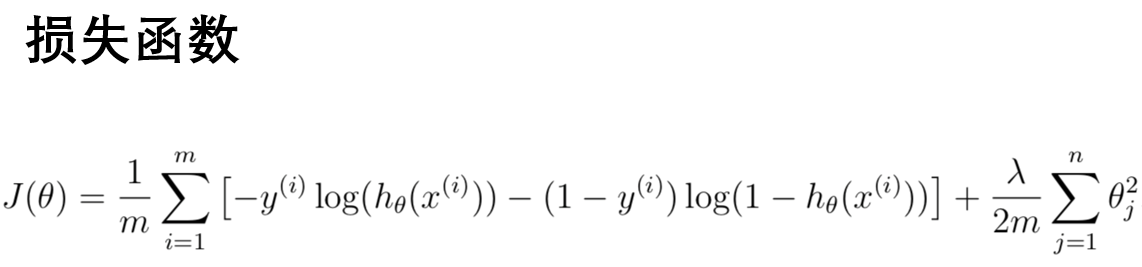

In [12]:
def costFunction(X,y,theta,lamda):#构造损失函数
    A=sigmoid(X @ theta) #y^
    
    first= y * np.log(A)
    second= (1-y) * np.log(1-A)
    reg= np.sum(np.power(theta[1:],2)) * (lamda /(2*len(X)))#正则化项,lamda--正则化参数
    
    return -np.sum(first + second)/ len(X) + reg #此处first+second结果是向量的形式，为返回一个值，需要对其进行累加求和,m=len(X)

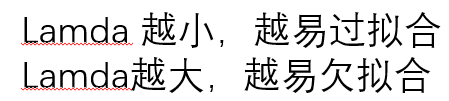

In [13]:
theta = np.zeros((28,1))#创建（28，1）全0矩阵，保证X @ theta与y的维度相同
theta.shape

(28, 1)

In [14]:
lamda=1 

In [15]:
cost_init = costFunction(X,y,theta,lamda)
print(cost_init)

0.6931471805599454


### 构造梯度下降函数  

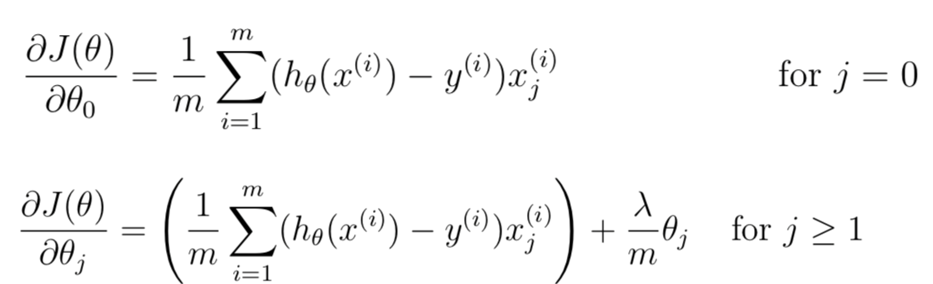

In [16]:
def gradientDescent(X,y,theta,alpha,iters,lamda):#梯度降落函数
    m=len(X)
    costs=[] #建立cost元组获取每次迭代时J（theta）的参数
    
    for i in range(iters):
        reg=theta[1:] * (lamda/len(X)) #从第二个参数开始取 （27，1）
        reg=np.insert(reg,0,values=0,axis=0) #第一行增加全0行，保证维度匹配（28，1），axis=0代表行
        A=sigmoid(X @ theta)
        theta = theta - (alpha / m) * (X.T @ (A - y)) - reg #X.T--X的转置，
        cost = costFunction(X,y,theta,lamda) #调用costFunction函数获取每次迭代时J（theta）的值
        costs.append(cost) #append函数会在数组后加上相应的元素,costs组存cost的值
        
        if i% 1000 ==0:# 每迭代100次打印一个值
            print(cost)
            
    return costs,theta

In [17]:
alpha=0.001
iters=200000
lamda=0.001

In [18]:
costs,final_theta = gradientDescent(X,y,theta,alpha,iters,lamda)

0.693134380798985
0.6818650671550655
0.672748697667896
0.6649382350210216
0.6579891999128368
0.6516587811169662
0.645806149345912
0.6403433508679413
0.6352109729552581
0.6303658897986846
0.625774925450325
0.6214114460854341
0.6172534280039077
0.613282288876784
0.6094821289408
0.6058392039109464
0.6023415373766955
0.598978623166525
0.5957411897406796
0.5926210098409752
0.5896107446192149
0.5867038148430397
0.5838942938016073
0.5811768178314223
0.5785465112720828
0.575998923306738
0.5735299746304319
0.5711359122705992
0.5688132711873028
0.5665588415252293
0.5643696405879912
0.5622428887672919
0.5601759887921506
0.5581665077721993
0.5562121615984903
0.5543108013388565
0.5524604013255084
0.5506590486826008
0.5489049340828341
0.547196343556383
0.5455316512037752
0.5439093126878609
0.5423278593995745
0.5407858932084393
0.5392820817223565
0.5378151539925351
0.536383896608914
0.5349871501393716
0.5336238058727042
0.5322928028309695
0.5309931250215411
0.5297237989032203
0.5284838910441562
0.527

In [19]:
final_theta

array([[ 1.2052072 ],
       [ 0.5825871 ],
       [ 1.13133192],
       [-1.92011714],
       [-0.83055737],
       [-1.28494641],
       [ 0.10189184],
       [-0.34252061],
       [-0.3413474 ],
       [-0.18126064],
       [-1.40955679],
       [-0.06604286],
       [-0.58032027],
       [-0.2460958 ],
       [-1.14671096],
       [-0.24322073],
       [-0.20113005],
       [-0.05872139],
       [-0.25848869],
       [-0.27166559],
       [-0.4910192 ],
       [-1.01575376],
       [ 0.01109593],
       [-0.28015729],
       [ 0.00479456],
       [-0.30974881],
       [-0.12601945],
       [-0.94013426]])

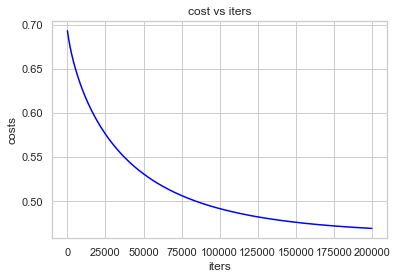

In [20]:
fig,ax = plt.subplots() #损失函数迭代可视化
ax.plot(np.arange(iters),costs,'b')   #列表
ax.set(xlabel='iters',ylabel='costs',title='cost vs iters')
plt.show()

In [21]:
def predict(X,theta): #构建可能性计算函数
    
    prob = sigmoid(X@theta)
    
    return [1 if x >= 0.5 else 0 for x in prob]

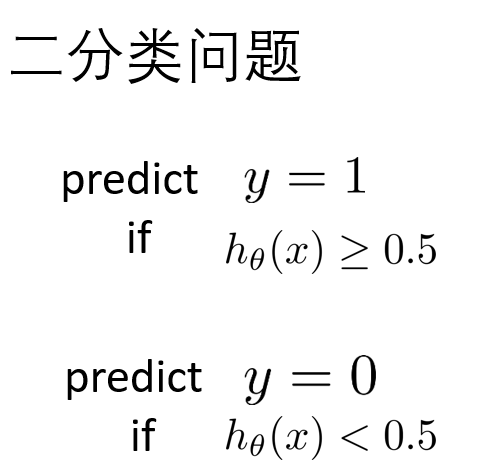

In [22]:
y_ = np.array(predict(X,final_theta))
y_pre = y_.reshape(len(y_),1)

acc  = np.mean(y_pre == y)

print(acc)

0.8305084745762712


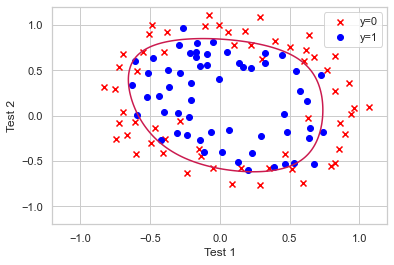

In [26]:
x = np.linspace(-1.2,1.2,200)#取从-1.2到1.2的100个点
xx,yy = np.meshgrid(x,x)#网格参数（矩阵）设置，（200，200）
z = feature_mapping(xx.ravel(),yy.ravel(),6).values#ravel将n×m的矩阵，变为1×mn的行向量。

zz = z @ final_theta 
zz = zz.reshape(xx.shape)#将zz维度转化为xx同维度

fig,ax = plt.subplots()#数据可视化
# c--散点颜色，marker--散点形状，label--散点标签
# data['Accepted']==0--判断接受值，['Test 1']--选择符合前面接收值的所有测试值
# data[data['Accepted']==0]['Test 1']表示在接受值为0时，所有exam1的符合值的横坐标
# data[data['Accepted']==0]['Test 1']表示在接受值为0时，所有exam2的符合值的纵坐标
ax.scatter(data[data['Accepted']==0]['Test 1'],data[data['Accepted']==0]['Test 2'],c='r',marker='x',label='y=0')
ax.scatter(data[data['Accepted']==1]['Test 1'],data[data['Accepted']==1]['Test 2'],c='b',marker='o',label='y=1')
ax.legend()#两个标签同时显示
ax.set(xlabel='Test 1',ylabel='Test 2')

plt.contour(xx,yy,zz,0)
plt.show()
